### Training of modified U-Net for Optic Disc on DRIONS-DB database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/05.03,02:40,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'#"1",""

In [19]:
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

In [20]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
# from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [21]:
# # running on CPU instead of GPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [22]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.7.0
TensorFlow version: 2.7.0


In [23]:
K.set_image_data_format('channels_first')

In [24]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [25]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [26]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [27]:
# h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRIONS_DB.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [28]:
# 341 cols
# 256 rows
def get_unet_light(img_rows=256, img_cols=256):
    
    inputs = Input((3, img_rows, img_cols))
        
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)
    
    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)
    
    model = Model(inputs, conv10)
    
    return model

In [29]:

model = get_unet_light(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

2022-02-24 11:30:06.625063: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 11:30:08.789126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14124 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:9e:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 256, 256  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 32, 256, 256  0           ['conv2d[0][0]']                 
                                )                                                             

#### DRIONS-DB

Accessing data, preparing train/validation sets division:

In [13]:
h5f_ukbb_masks = h5py.File("/SSD/home/michael/ground_truths.hdf5")

In [14]:
# X = h5f['DRIONS-DB/256 px/images']
# Y = h5f['DRIONS-DB/256 px/disc']

X = h5f_ukbb_masks['orig']
Y = h5f_ukbb_masks['masks']

X,Y

(<HDF5 dataset "orig": shape (100, 256, 256, 3), type "<i8">,
 <HDF5 dataset "masks": shape (100, 256, 256, 1), type "<i8">)

In [15]:
# X = h5f['DRIONS-DB/256 px/images']
# Y = h5f['DRIONS-DB/256 px/disc']

# X, Y

In [16]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5, random_state=None).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25

In [17]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

fold = 0

train_idx = train_idx_cv[fold]
test_idx = test_idx_cv[fold]

In [18]:
len(X), len(train_idx), len(test_idx)

(100, 80, 20)

#### Generator of augmented data:

In [19]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   # samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=90, width_shift_range=0.05, height_shift_range=0.05,
                                   zoom_range=(0.9, 1.9),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [20]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

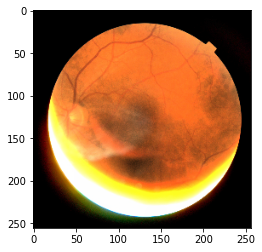

In [21]:
i=0
img = X[i].copy() / 255.0
plt.imshow(skimage.exposure.equalize_adapthist(img))

In [24]:
gen = data_generator(X, Y, 'test', batch_size=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


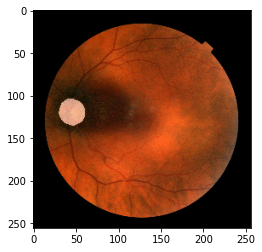

In [25]:
batch = next(gen)
img = np.moveaxis(batch[0][0], 0, 2).copy()
img[np.where(batch[1][0][0])] += 0.5
plt.imshow(img)

In [26]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

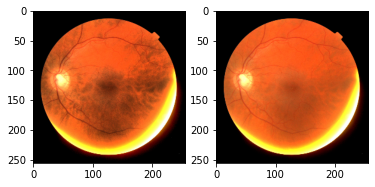

(20, 3, 256, 256) (20, 1, 256, 256)


In [26]:
X_valid, Y_valid, X_valid_orig, Y_valid_orig = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True, return_orig=True))
f,(ax1,ax2) = plt.subplots(1,2)
idx=4
ax1.imshow(np.rollaxis(X_valid[idx], 0, 3))
ax2.imshow(np.rollaxis(X_valid_orig[idx], 0, 3))
plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [26]:
arch_name = "UNet_UKBB_full_256px_fold"+str(fold)+"_SGD_high_augm_CLAHE_logDiceLoss"
arch_name = "blub"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)

/SSD/home/michael/brynhild/software/optic-nerve-cnn/models_weights/07.02,11:38,blub


In [27]:
history = model.fit(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99, #99 orig
                              max_queue_size=1,
                              # workers=20,
                              # use_multiprocessing=True,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              epochs=500, verbose=1,
                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500


2022-02-07 11:38:47.640214: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


99/99 [==============================] - 17s 105ms/step - loss: 3.2442 - mean_IOU_gpu: 0.0046 - dice_metric: 0.0089 - val_loss: 2.2435 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 2/500
65/99 [==================>...........] - ETA: 3s - loss: 1.8651 - mean_IOU_gpu: 0.0033 - dice_metric: 0.0060

KeyboardInterrupt: 

### Visual check

In [14]:
plt.plot(history.history['val_dice_metric'])

NameError: name 'history' is not defined

image #0


2022-02-06 22:36:29.921469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


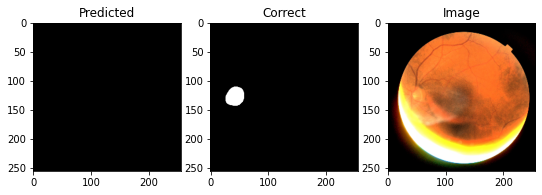

IOU: 0.0
Dice: 0.0
image #1


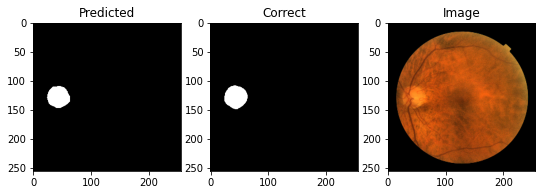

IOU: 0.9149277806282043
Dice: 0.9581033345387511
image #2


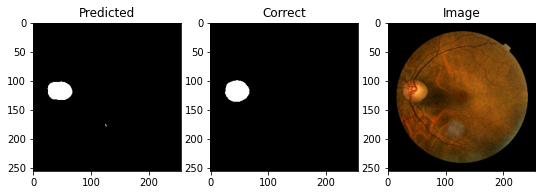

IOU: 0.875806450843811
Dice: 0.9370209083945109
image #3


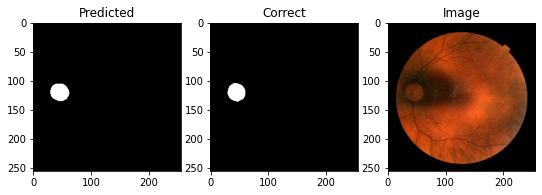

IOU: 0.9261577129364014
Dice: 0.9630174424926699
image #4


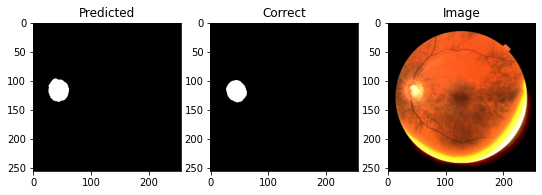

IOU: 0.8285714387893677
Dice: 0.9091771986188782
image #5


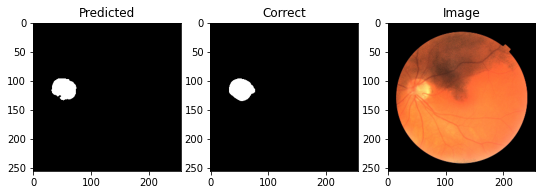

IOU: 0.886432945728302
Dice: 0.941905362596126
image #6


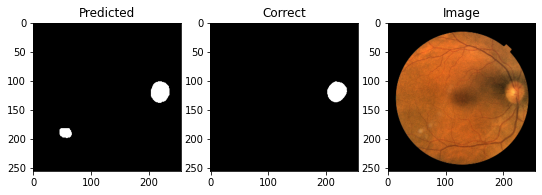

IOU: 0.7060677409172058
Dice: 0.8292927152171637
image #7


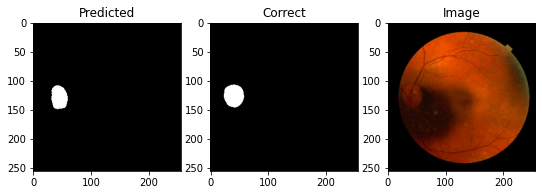

IOU: 0.6749585270881653
Dice: 0.8089442111171936
image #8


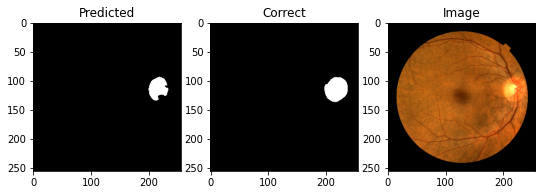

IOU: 0.7016491889953613
Dice: 0.8289663906860576
image #9


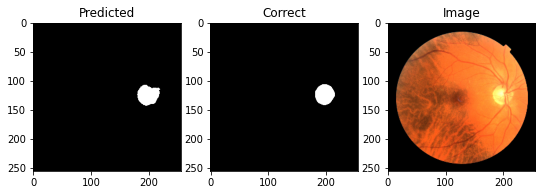

IOU: 0.8207023739814758
Dice: 0.9020288156386397
image #10


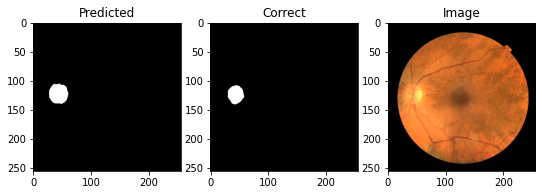

IOU: 0.7328326106071472
Dice: 0.8445960910450488
image #11


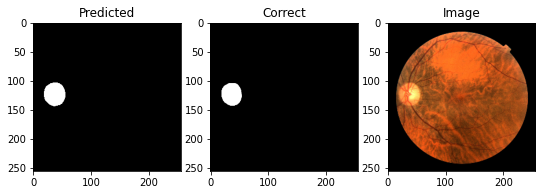

IOU: 0.9275603890419006
Dice: 0.961904596141031
image #12


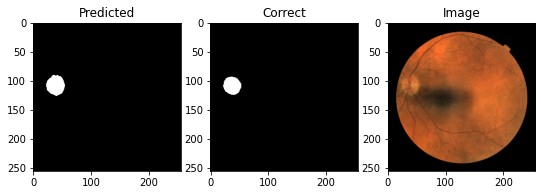

IOU: 0.8625866174697876
Dice: 0.9251490473351859
image #13


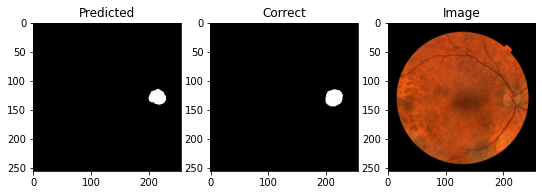

IOU: 0.8143460154533386
Dice: 0.8976305869797347
image #14


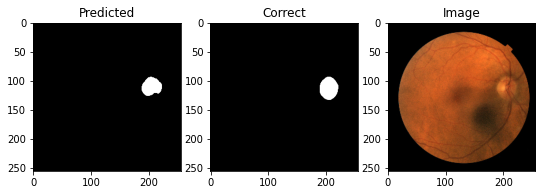

IOU: 0.7733847498893738
Dice: 0.8730026716048378
image #15


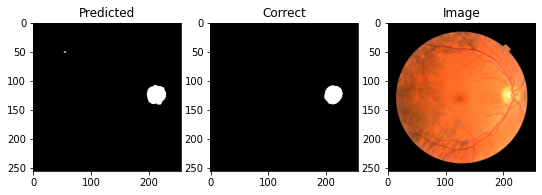

IOU: 0.8935447335243225
Dice: 0.9459809232890769
image #16


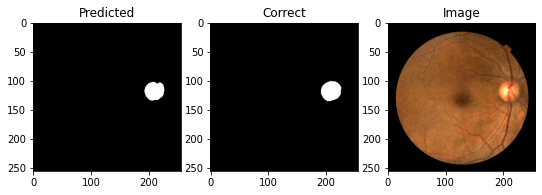

IOU: 0.900419294834137
Dice: 0.9516340675316367
image #17


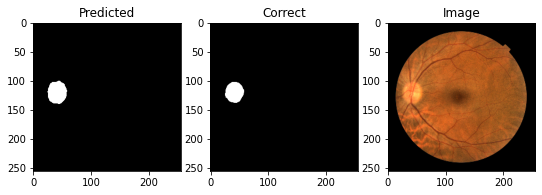

IOU: 0.8623327016830444
Dice: 0.9276390989422555
image #18


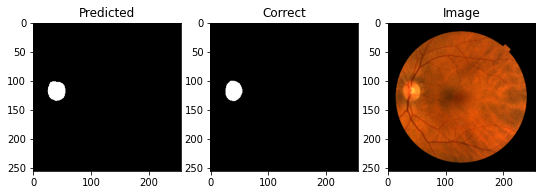

IOU: 0.9186320900917053
Dice: 0.9590651382328113
image #19


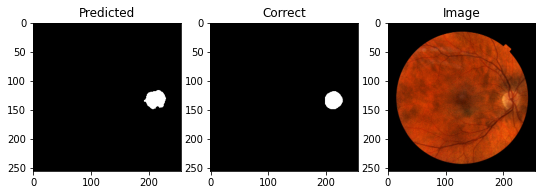

IOU: 0.7772877812385559
Dice: 0.8759846159454647


In [31]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

Showing the best and the worst cases:

In [ ]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    batch_X = X[img_no:img_no + 1]
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = Y[img_no:img_no + 1]
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(X[img_no])
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('drions_db_fold_0_{}_case_image.png'.format(file_suffix), X[img_no])
    plt.imsave('drions_db_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('drions_db_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {} (best)'.format(pred_iou[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {} (worst)'.format(pred_iou[worst_idx]))

# Predicting UKBB in batches

In [24]:
loadModel()

Loading weights from /SSD/home/michael/brynhild/software/optic-nerve-cnn/models_weights/04.02,1850,blub/last_checkpoint.hdf5

max val mean IOU: 0.7899100184440613, at row:
epoch               423.000000
dice_metric           0.889247
loss                  0.089686
mean_IOU_gpu          0.806644
val_dice_metric       0.860551
val_loss              0.126145
val_mean_IOU_gpu      0.789910
Name: 423, dtype: float64

max val dice_metric: 0.8605507016181946, at row:
epoch               423.000000
dice_metric           0.889247
loss                  0.089686
mean_IOU_gpu          0.806644
val_dice_metric       0.860551
val_loss              0.126145
val_mean_IOU_gpu      0.789910
Name: 423, dtype: float64


In [25]:
# fct for finding potential OD candidates using CV2

import matplotlib.patches as patches
import cv2

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    return labeled_img
    # plt.imshow(labeled_img)

In [30]:
# multibatch function
def batch_od_detection(batchno):
    
#     print('2')
#     # we need to build the model for every batch
    
#     K.set_session(tf.compat.v1.Session())
    
#     # as we only predict, I use CPU not GPU:
        
#     os.environ["CUDA_VISIBLE_DEVICES"] = ""
#     print('2.2')
#     model = get_unet_light(img_rows=256, img_cols=256)
#     print('2.3')
#     model.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.95),
#                   loss=log_dice_loss,
#                   metrics=[mean_IOU_gpu, dice_metric])
#     print('2.4')
#     model.summary()
#     loadModel()
#     print('2.5')
    
    h5f_ukbb = h5py.File("/SSD/scratch/optic_disc/resized_256px_batch"+str(batchno)+".hdf5")
    files=[os.path.split(i.decode("utf-8"))[1] for i in h5f_ukbb['filenames']]

    od_df = pd.DataFrame(index=files, columns=['width', 'height', 'area', 'center_x_y'])
        
    process = h5f_ukbb['raw_256px']
    idx = range(0,len(process))
    batch_ukb = [process[i] for i in idx]
    batch_ukb = np.array(batch_ukb).copy()
    batch_ukb = tf_to_th_encoding(batch_ukb)
    batch_ukb = th_to_tf_encoding(batch_ukb)
    batch_ukb = batch_ukb / 255.0
    batch_ukb = [skimage.exposure.equalize_adapthist(batch_ukb[i]) for i in range(len(batch_ukb))]
    batch_ukb = np.array(batch_ukb)
    batch_ukb = tf_to_th_encoding(batch_ukb)
    
    print('5')
    
    # optic disc center must be in 1/3 left 2/3 top third
    # asterisk indicates allowed boxes
    #  - - -
    # | | | |
    #  - - -
    # |*| |*|
    #  - - -
    # | | | |
    #  - - -
    
    print('aloha')
    
    top_limit = 256/3
    bottom_limit = 256/3*2

    left_limit = 256/3
    right_limit = 256/3*2

    for batch_i in range(0,len(files)):

        file = files[batch_i]
        if '21015' in file:
            side = 'left'
        else:
            side = 'right'

        out = (model.predict(batch_ukb[batch_i:batch_i+1])[0, 0] > 0.5).astype(np.float64)
        out_cv2 = (out * 255).astype(np.uint8)
        # f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)
        # ax1.imshow(process[batch_i])
        # ax1.set_title('original')
        # ax2.imshow(np.rollaxis(batch_ukb[batch_i],0,3))
        # ax2.set_title('augmented')
        # ax3.imshow(out)
        # ax3.set_title('raw output')
        # ax4.set_title('OD prediction')

        # computations
        num_labels, labels_im, stats, d = cv2.connectedComponentsWithStats(out_cv2)

        if len(labels_im) > 0:
            labeled_img = imshow_components(labels_im)
            # ax4.imshow(labeled_img)

        else:
            tmp=1
            # ax4.imshow()


        candidate_df = pd.DataFrame(columns=['width','height','area','center_x_y','within_box'])
        for idx,i in enumerate(stats[1:]):
            width = i[2]
            height = i[3]
            area = i[4]
            center_x = i[0] + width/2
            center_y = i[1] + height/2
            # rect = patches.Rectangle((i[0], i[1]), i[2], i[3], linewidth=1, edgecolor='r', facecolor='none')
            # ax4.add_patch(rect)

            # limits
            if side == 'left':
                if (center_x < left_limit) & (center_y < bottom_limit) & (center_y > top_limit):
                    within_box = True
                else:
                    within_box = False
            else:
                if (center_x > right_limit) & (center_y < bottom_limit) & (center_y > top_limit):
                    within_box = True
                else:
                    within_box = False

            candidate_df.loc[len(candidate_df)] = [width,height,area,(center_x,center_y),within_box]


        # keeping only boxes that are within plausibility area
        # defining largest candidate as the correct one
        try:
            candidate_df = candidate_df[candidate_df['within_box']==True].sort_values('area',ascending=False)
            # ax4.scatter(candidate_df['center_x_y'].iloc[0][0], candidate_df['center_x_y'].iloc[0][1], marker='*', color='white')
            od_df.loc[file] = candidate_df.iloc[0][0:4]
        except Exception as e:
            print(e)
            od_df.loc[file] = [np.nan for i in range(0,4)]       


        # plt.tight_layout()
        # plt.show()
    
    print('haloa')
    
    
    od_df.to_csv("/SSD/scratch/optic_disc/OD_batch" + str(batchno) + ".csv")

In [ ]:
# from multiprocessing import Pool
# # import threading

# pool = Pool(10)

batches = [i for i in range(1,113)]

for i in batches:
    batch_od_detection(i)

# pool.map(batch_od_detection, batches[0:20])

# thread=threading.Thread(target=batch_od_detection, args=batches[0:20])
# thread.start()

In [ ]:
loadModel()

In [27]:
h5f_ukbb = h5py.File("/SSD/scratch/optic_disc/resized_256px_batch1.hdf5")
files=[os.path.split(i.decode("utf-8"))[1] for i in h5f_ukbb['filenames']]

od_df = pd.DataFrame(index=files, columns=['width', 'height', 'area', 'center_x_y'])

In [28]:
process = h5f_ukbb['raw_256px']
idx = range(0,len(process))
batch_ukb = [process[i] for i in idx]
batch_ukb = np.array(batch_ukb).copy()
batch_ukb = tf_to_th_encoding(batch_ukb)
batch_ukb = th_to_tf_encoding(batch_ukb)
batch_ukb = batch_ukb / 255.0
batch_ukb = [skimage.exposure.equalize_adapthist(batch_ukb[i]) for i in range(len(batch_ukb))]
batch_ukb = np.array(batch_ukb)
batch_ukb = tf_to_th_encoding(batch_ukb)

In [29]:
# %%timeit

batchno=1
od_df = pd.DataFrame(index=files, columns=['width', 'height', 'area', 'center_x_y'])
# optic disc center must be in 1/3 left 2/3 top third
# asterisk indicates allowed boxes
#  - - -
# | | | |
#  - - -
# |*| |*|
#  - - -
# | | | |
#  - - -

top_limit = 256/3
bottom_limit = 256/3*2

left_limit = 256/3
right_limit = 256/3*2
    
for batch_i in range(0,10):
    
    file = files[batch_i]
    if '21015' in file:
        side = 'left'
    else:
        side = 'right'
    
    out = (model.predict(batch_ukb[batch_i:batch_i+1])[0, 0] > 0.5).astype(np.float64)
    out_cv2 = (out * 255).astype(np.uint8)
    # f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)
    # ax1.imshow(process[batch_i])
    # ax1.set_title('original')
    # ax2.imshow(np.rollaxis(batch_ukb[batch_i],0,3))
    # ax2.set_title('augmented')
    # ax3.imshow(out)
    # ax3.set_title('raw output')
    # ax4.set_title('OD prediction')
    
    # computations
    num_labels, labels_im, stats, d = cv2.connectedComponentsWithStats(out_cv2)
    
    if len(labels_im) > 0:
        labeled_img = imshow_components(labels_im)
        # ax4.imshow(labeled_img)
        
    else:
        tmp=1
        # ax4.imshow()

    
    candidate_df = pd.DataFrame(columns=['width','height','area','center_x_y','within_box'])
    for idx,i in enumerate(stats[1:]):
        width = i[2]
        height = i[3]
        area = i[4]
        center_x = i[0] + width/2
        center_y = i[1] + height/2
        # rect = patches.Rectangle((i[0], i[1]), i[2], i[3], linewidth=1, edgecolor='r', facecolor='none')
        # ax4.add_patch(rect)
        
        # limits
        if side == 'left':
            if (center_x < left_limit) & (center_y < bottom_limit) & (center_y > top_limit):
                within_box = True
            else:
                within_box = False
        else:
            if (center_x > right_limit) & (center_y < bottom_limit) & (center_y > top_limit):
                within_box = True
            else:
                within_box = False
                
        candidate_df.loc[len(candidate_df)] = [width,height,area,(center_x,center_y),within_box]

    
    # keeping only boxes that are within plausibility area
    # defining largest candidate as the correct one
    try:
        candidate_df = candidate_df[candidate_df['within_box']==True].sort_values('area',ascending=False)
        # ax4.scatter(candidate_df['center_x_y'].iloc[0][0], candidate_df['center_x_y'].iloc[0][1], marker='*', color='white')
        od_df.loc[file] = candidate_df.iloc[0][0:4]
    except Exception as e:
        print(e)
        od_df.loc[file] = [np.nan for i in range(0,4)]       
        
    
    # plt.tight_layout()
    # plt.show()
    
od_df.to_csv("/SSD/scratch/optic_disc/tmp_OD_batch" + str(batchno) + ".csv")

2022-02-07 17:25:45.195596: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


In [15]:
tmp_df = pd.read_csv("~/tmp.csv", index_col=0)

In [16]:
tmp_df

,width,height,area,center_x_y
1018804_21015_0_0.png,36.0,36.0,1007.0,"(40.0, 117.0)"
1018804_21016_0_0.png,39.0,37.0,1129.0,"(209.5, 115.5)"
1018843_21015_1_0.png,38.0,37.0,988.0,"(57.0, 124.5)"
1018843_21016_1_0.png,31.0,30.0,761.0,"(209.5, 133.0)"
1018862_21015_0_0.png,39.0,40.0,1216.0,"(41.5, 121.0)"
...,...,...,...,...
1060258_21016_1_0.png,NaN,NaN,NaN,NaN
1060291_21015_0_0.png,NaN,NaN,NaN,NaN
1060291_21016_0_0.png,NaN,NaN,NaN,NaN
1060306_21015_0_0.png,NaN,NaN,NaN,NaN


### Loading model

In [30]:
def loadModel():
    load_model = True   # lock
    if not load_model:
        print('load_model == False')
    else:
        # specify file:
        #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
        #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'

        # or get the most recently modified file in a folder:
        model_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '04.02,1850,blub')

        model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
        if load_model and not os.path.exists(model_path):
            raise Exception('`model_path` does not exist')
        print('Loading weights from', model_path)

        if load_model:
            #with open(model_path + ' arch.json') as arch_file:
            #    json_string = arch_file.read()
            #new_model = model_from_json(json_string)
            model.load_weights(model_path)

        # Reading log statistics
        import pandas as pd

        log_path = os.path.join(model_folder, 'training_log.csv')
        if os.path.exists(log_path):
            log = pd.read_csv(log_path)
            if log['epoch'].dtype != 'int64':
                log = log.loc[log.epoch != 'epoch']
            print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
            print(log.loc[log['val_mean_IOU_gpu'].idxmax()])
            if 'val_dice_metric' in log.columns:
                print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
                print(log.loc[log['val_dice_metric'].idxmax()])
            if 'val_dice' in log.columns:
                print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
                print(log.loc[log['val_dice'].idxmax()])

# trying with my own images

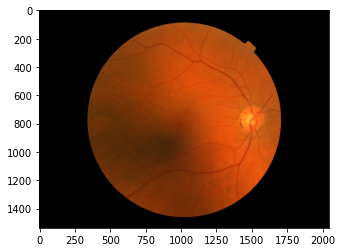

In [157]:
img = Image.open('/SSD/home/michael/sensitive/ukbb/fundus/raw/CLRIS/1614092_21016_0_0.png')
plt.imshow(img)

In [73]:
img = Image.open('/SSD/home/michael/sensitive/ukbb/fundus/raw/CLRIS/1614092_21016_0_0.png')
center = [int(i/2) for i in img.size]
center[0] = img.size[0] * 2 / 3
radius = 700
img = img.crop((center[0]-radius,center[1]-radius,center[0]+radius,center[1]+radius,))
img=img.resize((256,256))

In [74]:
img=np.array(img)

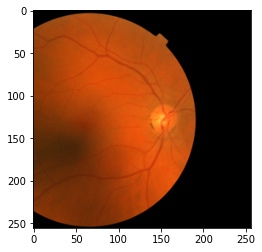

In [75]:
plt.imshow(img)

In [76]:
from PIL import ImageEnhance

In [77]:
pilimg = Image.fromarray(np.uint8(img))

enhancer = ImageEnhance.Contrast(pilimg)

factor = 1.5 #increase contrast
im_output = enhancer.enhance(factor)
# im_output.save('more-contrast-image.png')

In [78]:
batch_X = [img]
batch_X = np.array(batch_X).copy()
batch_X = tf_to_th_encoding(batch_X)

In [79]:
im=np.array(img)
im.shape

(256, 256, 3)

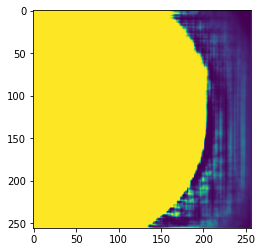

In [80]:
plt.imshow(model.predict(batch_X)[0, 0])

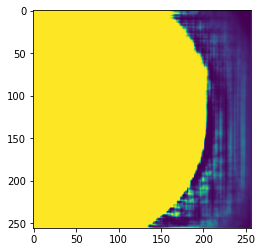

In [81]:
plt.imshow(model.predict(batch_X)[0, 0])

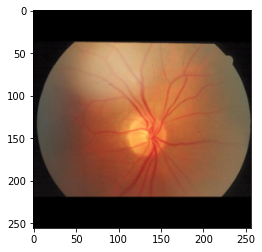

In [38]:
plt.imshow(X[-1])

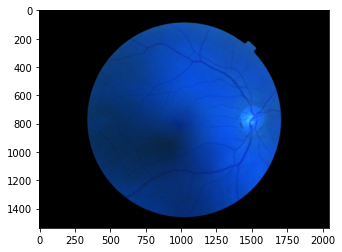

In [158]:
import cv2

img = cv2.imread('/SSD/home/michael/sensitive/ukbb/fundus/raw/CLRIS/1614092_21016_0_0.png')
plt.imshow(img)

In [161]:
img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

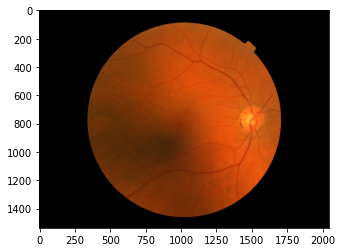

In [170]:
plt.imshow(img1)

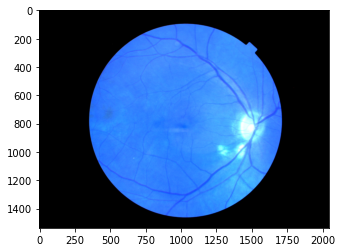

In [212]:
img = cv2.imread(tmp[0].decode("utf-8"))
plt.imshow(img)